In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import itertools
import os

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.agents.elegantrl.models import DRLAgent as DRLAgent_erl

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

/home/henry/miniconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import datetime

In [3]:
from data_processor.indicator import add_all_indicators, add_tech_indicator, tech_indicator_only


In [4]:
import data_processor.config

In [5]:
price_df = pd.read_parquet("./data/sz50_price.parquet")
fund_df = pd.read_parquet("./data/sz50_fundament.parquet")


In [6]:
df = add_all_indicators(price_df, fund_df)


In [7]:
available_tics = df.set_index('date').loc[data_processor.config.FIRST_DAY_OF_2009].tic.tolist()

In [8]:
tmp_list = []
for tic in available_tics:
    tmp_df = df[df['tic'] == tic]
    tmp_list.append(tmp_df)
    
df = pd.concat(tmp_list, ignore_index=True)
    

In [9]:
train = data_split(df, "2009-01-01", "2020-01-01")
trade = data_split(df, "2020-01-01", "2022-01-01")


In [10]:
indicators = data_processor.config.INDICATORS
# indicators = ["SMA_20", "SMA_60", "SMA_120", "macdhist", "CCI", "RSI", "NATR", "ADOSC"]


In [11]:
n_indicators = len(indicators)
n_indicators


17

In [12]:
stock_dimension = len(df.tic.unique())
stock_dimension


34

In [13]:
state_space = 1 + (2 + n_indicators) * stock_dimension
state_space


647

In [14]:
env_kwargs = {
    "hmax": 1000,
    "initial_amount" : 10000000,
    # "initial_list": [10000000] + [0 for i in range(stock_dimension)],
    # buy and sell cost for each stock
    "num_stock_shares" : [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [15]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent_erl

### SAC

In [24]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1"
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [25]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac_4
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 55       |
|    time_elapsed    | 193      |
|    total_timesteps | 10700    |
| train/             |          |
|    actor_loss      | 1.24e+06 |
|    critic_loss     | 2.03e+09 |
|    ent_coef        | 0.273    |
|    ent_coef_loss   | 513      |
|    learning_rate   | 0.0001   |
|    n_updates       | 10599    |
|    reward          | -8.87027 |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 54        |
|    time_elapsed    | 391       |
|    total_timesteps | 21400     |
| train/             |           |
|    actor_loss      | 9.59e+05  |
|    critic_loss     | 1.46e+09  |
|    ent_coef        | 0.795     |
|    ent_coef_loss   | 90.4      |
|    learning_rate   | 0.0001    |
|    n_updates       | 21299     |
| 

### DDPG

In [21]:
DDPG_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001
}

agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001}
Using cuda device


In [22]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100000)

Logging to tensorboard_log/ddpg_1
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 100       |
|    time_elapsed    | 106       |
|    total_timesteps | 10700     |
| train/             |           |
|    actor_loss      | -8.77e+04 |
|    critic_loss     | 2.89e+09  |
|    learning_rate   | 0.0001    |
|    n_updates       | 8025      |
|    reward          | 2.8395762 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 95        |
|    time_elapsed    | 223       |
|    total_timesteps | 21400     |
| train/             |           |
|    actor_loss      | -2.81e+04 |
|    critic_loss     | 2.01e+08  |
|    learning_rate   | 0.0001    |
|    n_updates       | 18725     |
|    reward          | 36.393936 |
----------------------------------
day: 2674, episode: 10
begin_total_asset: 10000000.00
en

In [23]:
model = trained_ddpg

## Backtest

In [24]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [25]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=model, 
    environment = e_trade_gym)

hit end!


In [26]:
df_account_value.tail()

,date,account_value
481,2021-12-27,1.732895e+07
482,2021-12-28,1.734765e+07
483,2021-12-29,1.679168e+07
484,2021-12-30,1.703672e+07
485,2021-12-31,1.693918e+07


In [29]:
df_account_value.to_csv("./sz50_without_fund.csv")

In [27]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.314271
Cumulative returns     0.693918
Annual volatility      0.276077
Sharpe ratio           1.130500
Calmar ratio           0.940534
Stability              0.597871
Max drawdown          -0.334141
Omega ratio            1.212157
Sortino ratio          1.651742
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.216290
Daily value at risk   -0.033544
dtype: float64


In [28]:
from data_processor.ChinaStockDownloader import single_stock_query

baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")

login success!
logout success!


In [29]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")
baseline_df = baseline_df.apply(pd.to_numeric, errors='ignore')
stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
login success!
logout success!
Annual return          0.030354
Cumulative returns     0.059365
Annual volatility      0.207159
Sharpe ratio           0.248251
Calmar ratio           0.127942
Stability              0.258280
Max drawdown          -0.237251
Omega ratio            1.043889
Sortino ratio          0.346802
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977931
Daily value at risk   -0.025896
dtype: float64


In [30]:
test_ret = get_daily_return(df_account_value)
base_ret = get_daily_return(baseline_df, 'close')

In [31]:
print("==============Compare to SZ50===========")
%matplotlib inline

import pyfolio

==============Compare to SZ50===========


In [32]:
test_ret.index = pd.DatetimeIndex(test_ret.index.date)
base_ret.index = pd.DatetimeIndex(base_ret.index.date)

In [ ]:
import quantstats as qs

qs.reports.html(with_fund_ret, test_ret)

Start date,2020-01-02
End date,2021-12-31
Total months,23
,Backtest
Annual return,31.427%
Cumulative returns,69.392%
Annual volatility,27.608%
Sharpe ratio,1.13
Calmar ratio,0.94
Stability,0.60
Max drawdown,-33.414%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.41,2021-02-10,2021-08-20,NaT,NaN
1,14.15,2020-03-05,2020-03-19,2020-04-17,32
2,9.64,2020-01-13,2020-02-03,2020-02-20,29
3,9.24,2020-07-13,2020-07-16,2020-08-28,35
4,9.08,2020-09-02,2020-10-27,2020-12-04,68


Stress Events,mean,min,max
New Normal,0.12%,-7.34%,5.89%


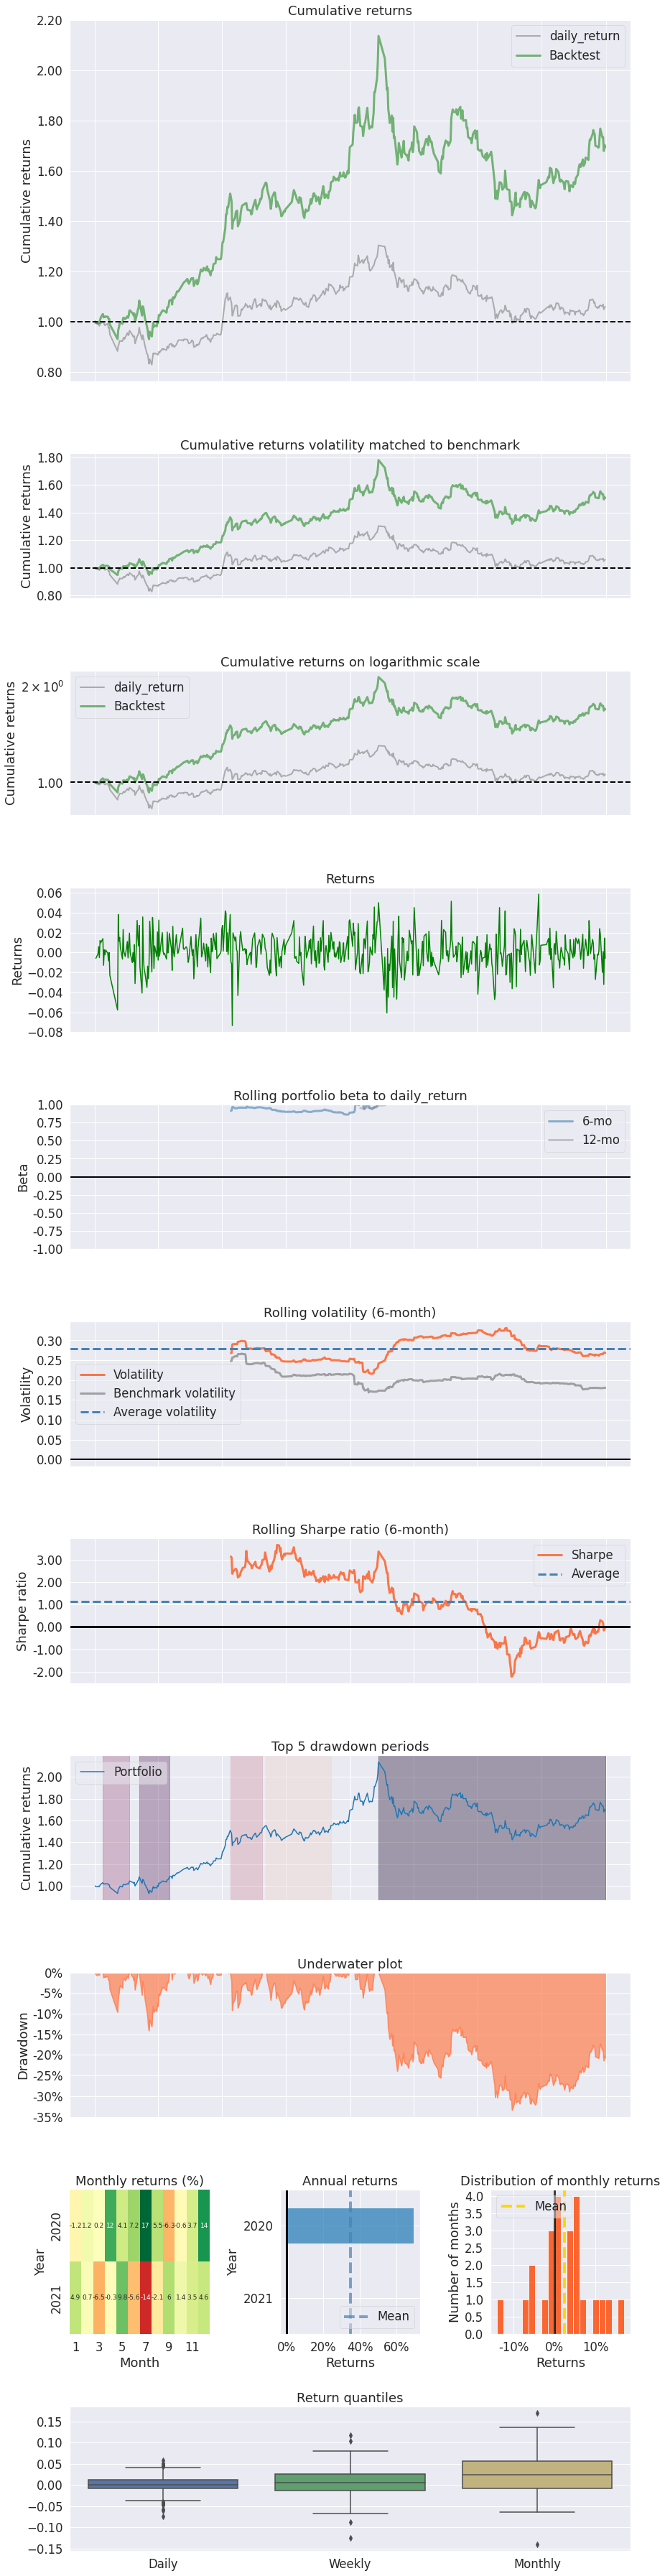

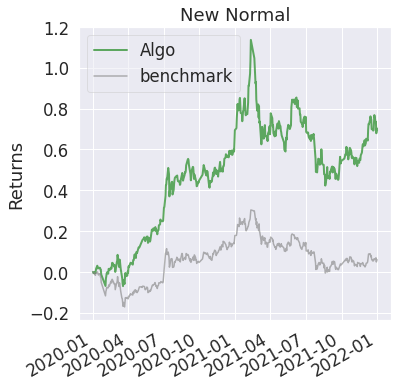

In [33]:
pyfolio.create_full_tear_sheet(returns=test_ret, benchmark_rets=base_ret)